In [1]:
import numpy as np
import scipy as sc
from numba import njit, jit
from joblib import Parallel, delayed
import matplotlib.pyplot as plt


In [7]:

mass = 48
N = 864

In [70]:
def initialisation(T, rho):
    M = (N/4)**(1/3)
    L = (N/rho)**(1/3)
    a = L/M
    vel = np.random.normal(0, np.sqrt(T/mass), 3*N)

    v0 = np.zeros(3)
    for i in range(N):
        v0 += vel[3*i:3*i+3]
    v0 /= N

    for i in range(N):
        vel[3*i:3*i+3] -= v0
    

    x0 = np.zeros(3*N)

    for j in range(12):
        for k in range(12):
            for l in range(6):
                x0[3*(72*j + 6*k + l) + 2] = 1e-10 + j/2 * a + j%2*a/2
                
                if j%2==0:
                    x0[3*(72*j + 6*k + l) + 0] = 1e-10 + (l * a + k%2 * a/2)
                    x0[3*(72*j + 6*k + l) + 1] = 1e-10 + ((k)//2 * a + k%2*a/2)

                else:
                    x0[3*(72*j + 6*k + l) + 0] = 1e-10 + (l * a + k%2 * a/2) +(a/2 - k%2*a)
                    x0[3*(72*j + 6*k + l) + 1] = 1e-10 + ((k)//2 * a + k%2*a/2)

    return x0, vel, a, L

@njit(fastmath=True)
def melting(pos, a):
    return np.sum(np.cos(4*np.pi/a * pos))

@njit(fastmath=True)
def dLJ(d):
    return 48 * (d**(-13) -  0.5 * d**(-7))

@njit(fastmath=True)
def force(pos, L):
    f = np.zeros(3*N)
    for i in range(N):
        for j in range(i+1, N):
            r = np.ones(3)
            for k in range(3):
                r[k] = pos[3*j+k]
                if abs(pos[3*i+k] - pos[3*j+k]) < L/2:
                    r[k] = pos[3*j+k]
                elif pos[3*i+k] - pos[3*j+k] > L/2:
                    r[k] = pos[3*j +k] + L
                elif pos[3*i+k] - pos[3*j+k] < -L/2:
                    r[k] = pos[3*j +k] - L
            d = np.linalg.norm(pos[3*i:3*i+3] - r)
            f[3*i:3*i+3] += dLJ(d) * (pos[3*i:3*i+3] - r)/d
            f[3*j:3*j+3] -= dLJ(d) * (pos[3*i:3*i+3] - r)/d

    return f

@njit(fastmath=True)
def temp(vel):
    t = 0
    for i in range(N):
        t+=np.linalg.norm(vel[3*i:3*i+3])**2
    return mass * t / (3 * N)

def vverlet(T, rho, tmax, h, tburn):
    init = initialisation(T=T, rho=rho)
    pos1 = init[0]
    #pos2 = pos1
    v1 = init[1]
    a = init[2]
    L = init[3]

    Temp = []
    time = []
    melt = []

    Temp.append(temp(v1))
    time.append(0)
    melt.append(melting(pos1, a))
    t = 0
    while t <= tmax:
        t+=h
        F = force(pos1, L)
        v1 += h/(2*mass) * F
        pos1 = pos1 + h * v1
        F = force(pos1, L)
        v1 += h/(2*mass) * F

        x = np.argwhere(pos1 > L)
        pos1[x] -= L
        x = np.argwhere(pos1 < 0)
        pos1[x] += L
        print(t)
        Temp.append(temp(v1))
        time.append(t)
        melt.append(melting(pos1, a))

    return v1, time, Temp, melt


v = vverlet(1.38, 0.55, 5, 0.016, 0)





0.016
0.032
0.048
0.064
0.08
0.096
0.112
0.128
0.14400000000000002
0.16000000000000003
0.17600000000000005
0.19200000000000006
0.20800000000000007
0.2240000000000001
0.2400000000000001
0.2560000000000001
0.27200000000000013
0.28800000000000014
0.30400000000000016


1.3861365548327045


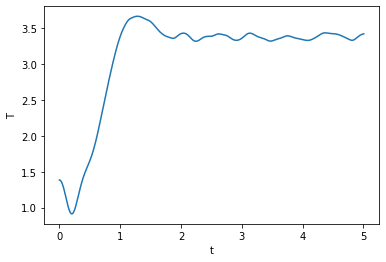

In [67]:
print(v[2][0])

plt.plot(v[1], v[2])
plt.xlabel("t")
plt.ylabel("T")
plt.show()

2592.0


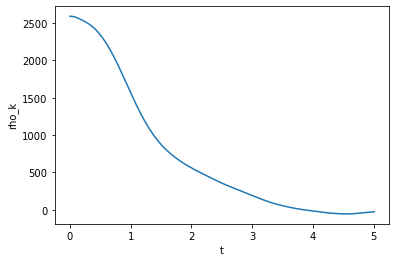

In [68]:
print(v[3][0])

plt.plot(v[1], v[3])
plt.xlabel("t")
plt.ylabel("rho_k")
plt.show()

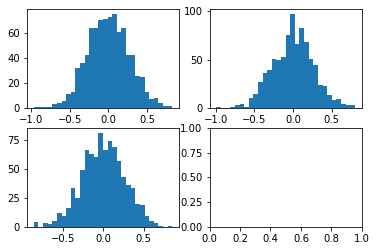

In [69]:

f, ax = plt.subplots(nrows=2, ncols=2)

ax[0, 0].hist(v[0][::3], bins=30)
ax[1, 0].hist(v[0][1::3], bins=30)
ax[0, 1].hist(v[0][2::3], bins=30)
plt.show()

In [13]:
a = np.array([1, 2, 3, 4, 5])
b = np.array([2, 3, 4, 1, 1])
c = np.ones(5)

c[:] = a[:] + b[:]
print(c)

x = np.argwhere(c < 6)
print(x)

c[x] += 10

print(c)

[3. 5. 7. 5. 6.]
[[0]
 [1]
 [3]]
[13. 15.  7. 15.  6.]
